# Data Mining the Water Table

### Project Overview & Problem Statement

Data for this project is sourced from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water. It is hosted by DRIVENDATA as an open source project aimed at tackling social challenges with Data Science. https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

The goal of the project is to effectively predict the operating condition of a water front for each record in the data. Each record or waterfront has 30+ features associated with it.

There are 3 files used  for the analyses:

- labels.csv: depicts whether a waterfront is functional, not functional, or functional needs repair
- values.csv: contains fields for all the features of the waterfronts
- competition_test.csv: features used in predicting water table status with predictions submitted on the competition site 

In [1]:
! pip install catboost
! pip install h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
%matplotlib inline
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

     |████████████████████████████████| 65.9MB 59kB/s 
     |████████████████████████████████| 128.8MB 1.3MB/s 
  Created wheel for h2o: filename=h2o-3.30.0.7-py2.py3-none-any.whl size=128865965 sha256=b88d9f46f9fbccc35fbfa32859c51427a42894a0a02bbf0f76c06de05a901a5c
  Stored in directory: /root/.cache/pip/wheels/a6/c2/6d/9612d426d2c947be23a8cd2d0156a9107927de630b8821ecea
Successfully built h2o


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in data
labels = pd.read_csv("labels.csv")
values = pd.read_csv("values.csv")
X_comp = pd.read_csv("competition_test.csv")

In [3]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
# merge both dataframes on id to match indices

df = pd.merge(labels, values, on= "id")
y = df[['status_group']]
X = df.drop(['status_group','id'], axis = 1)

In [6]:
#check for missing values in the target data 

y.isnull().sum()

status_group    0
dtype: int64

Text(0, 0.5, 'Frequency')

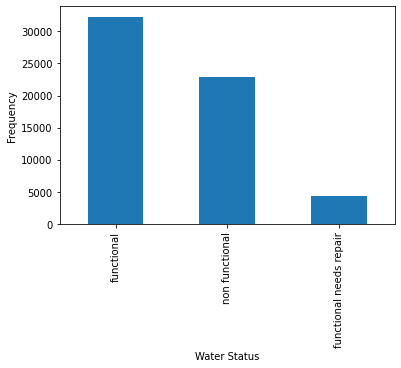

In [7]:
# Frequency plot of target values
y['status_group'].value_counts().plot(kind='bar')
plt.xlabel('Water Status')
plt.ylabel('Frequency')

**Notes** : The chart above shows the distribution of the target variables. There's a class imbalance in the data which will be addressed in subsequnt models.  Most water sources are functional while fewer are functional needing repairs

Now to review the X features in the dataset

In [8]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

**Notes** Some columns have missing values. Will attempt a few techniques to deal with missing values.scheme_name has significantly more missing values than other columns

In [10]:
# Will split columns into Categorical and non Categroical fields to explore futher
X_categ = X.select_dtypes(include=['object'])
X_num_list = list(set(X.columns)-set(X_categ.columns))
X_num = X[X_num_list]

### Exploratoring numerical variables

In [11]:
X_num.describe()

,gps_height,num_private,longitude,amount_tsh,district_code,population,region_code,latitude,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000
mean,668.297239,0.474141,34.077427,317.650385,5.629747,179.909983,15.297003,-5.706033e+00,1300.652475
std,693.116350,12.236230,6.567432,2997.574558,9.633649,471.482176,17.587406,2.946019e+00,951.620547
min,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.164944e+01,0.000000
25%,0.000000,0.000000,33.090347,0.000000,2.000000,0.000000,5.000000,-8.540621e+00,0.000000
50%,369.000000,0.000000,34.908743,0.000000,3.000000,25.000000,12.000000,-5.021597e+00,1986.000000
75%,1319.250000,0.000000,37.178387,20.000000,5.000000,215.000000,17.000000,-3.326156e+00,2004.000000
max,2770.000000,1776.000000,40.345193,350000.000000,80.000000,30500.000000,99.000000,-2.000000e-08,2013.000000


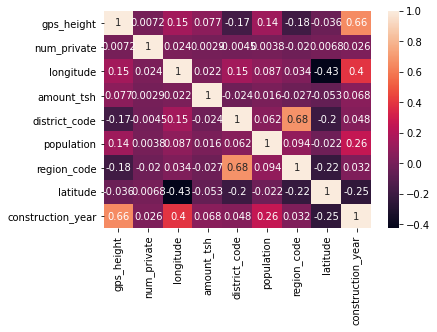

In [12]:
sns.heatmap(X_num.corr(), annot=True)

In [13]:
X_num.construction_year.value_counts().head(10)

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
Name: construction_year, dtype: int64

In [14]:
X_num.gps_height.value_counts().head(10)

 0       20438
-15         60
-16         55
-13         55
-20         52
 1290       52
-14         51
 303        51
-18         49
-19         47
Name: gps_height, dtype: int64

In [15]:
X_num.population.value_counts().head(10)

0      21381
1       7025
200     1940
150     1892
250     1681
300     1476
100     1146
50      1139
500     1009
350      986
Name: population, dtype: int64

In [16]:
X_num.latitude.value_counts().head(10)

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
-7.056923e+00       2
-7.175174e+00       2
-6.990731e+00       2
-6.978755e+00       2
-6.994704e+00       2
Name: latitude, dtype: int64

In [17]:
X_num.longitude.value_counts().head(10)

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
33.006275       2
39.103950       2
37.542785       2
36.802490       2
39.098374       2
Name: longitude, dtype: int64

**Notes**: construction_year and gps_height have large number of 0 values leading to high correlation seen in the plot. Region code and district code also show a positive correlation as both are also geographically based.


**Solutions:**
- **construction_year:** Treat 0 values as missing values and attempt to impute instead
- **gps_height** Treat 0 values as missing values and attempt to impute instead

### Exploratory Categorical variables

In [18]:
X_categ.isnull().sum()

date_recorded                0
funder                    3635
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

In [19]:
X_categ.describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


In [20]:
# Checking column values to compare columns
# Note the date_recorded column is captured as on object but we will ignore the field in the output below

for col in X_categ:
    print(col,':', X_categ[col].unique())

date_recorded : ['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03'
 '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15' '2012-10-20'
 '2011-08-04' '2011-07-04' '2011-09-04' '2011-07-22' '2011-02-22'
 '2011-02-27' '2013-02-10' '2011-10-04' '2013-11-03' '2013-01-21'
 '2013-01-16' '2011-07-11' '2013-03-05' '2013-03-16' '2011-03-23'
 '2011-03-16' '2013-03-19' '2011-03-11' '2011-02-23' '2013-03-28'
 '2011-07-16' '2011-03-27' '2013-02-11' '2013-10-03' '2011-03-12'
 '2011-07-07' '2013-01-15' '2013-03-18' '2012-10-22' '2013-02-05'
 '2011-07-27' '2011-04-04' '2013-02-21' '2011-08-18' '2011-07-31'
 '2011-08-01' '2011-07-14' '2013-02-22' '2013-07-03' '2013-08-03'
 '2013-01-22' '2011-03-22' '2013-05-03' '2013-01-19' '2013-02-09'
 '2011-01-04' '2013-02-04' '2011-03-05' '2011-03-31' '2013-02-27'
 '2011-08-07' '2011-03-30' '2012-10-23' '2011-03-02' '2011-03-04'
 '2013-03-14' '2012-10-18' '2011-08-08' '2011-09-05' '2011-0

### Comments: 

- date_recorded shows up as categorical but the format needs to be changed to date type if it is to be used further in the analysis. 
- Certain columns appear to be duplicates or very similar with high levels of cardinality.This will be addressed in the below section

## MODEL 0: The "Kitchen Sink" approach

Fitting a default CatBoost Model on the train dataset and predicting on the test dataset to record 2 main outcomes: 
1. **Capture feature importances from the fit procedure**. The plan is to use the most important features later on with further preprocessing and parameter tuning
2. **Capture classification results of this "base model"** to compare future models and see which ones perform best. 



In [21]:
#Split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [22]:
#Setup CatBoost classification and fit the data
#This is done with all columns and all missing values as CatBoost treats missing values as missing for a reason
cat_features = X_categ.columns
cb = CatBoostClassifier(cat_features = cat_features, 
                        loss_function = 'MultiClass',
                        random_seed=42,
                        task_type = 'GPU')

train_dataset = Pool(data=X_train.astype(str),
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_test.astype(str),
                    label=y_test,
                    cat_features=cat_features)

cb.fit(train_dataset)
y_pred_catb = cb.predict(eval_dataset, prediction_type = 'Class')


Learning rate set to 0.138847
0:	learn: 1.0445226	total: 24.5ms	remaining: 24.5s
1:	learn: 0.9876162	total: 48.8ms	remaining: 24.4s
2:	learn: 0.9421386	total: 72.8ms	remaining: 24.2s
3:	learn: 0.9086434	total: 95ms	remaining: 23.6s
4:	learn: 0.8678440	total: 117ms	remaining: 23.4s
5:	learn: 0.8269872	total: 141ms	remaining: 23.3s
6:	learn: 0.7977695	total: 163ms	remaining: 23.2s
7:	learn: 0.7740068	total: 187ms	remaining: 23.2s
8:	learn: 0.7568894	total: 211ms	remaining: 23.2s
9:	learn: 0.7388604	total: 250ms	remaining: 24.7s
10:	learn: 0.7209773	total: 273ms	remaining: 24.6s
11:	learn: 0.7091785	total: 297ms	remaining: 24.4s
12:	learn: 0.6986728	total: 321ms	remaining: 24.3s
13:	learn: 0.6898033	total: 344ms	remaining: 24.2s
14:	learn: 0.6818348	total: 366ms	remaining: 24s
15:	learn: 0.6766739	total: 390ms	remaining: 24s
16:	learn: 0.6724974	total: 412ms	remaining: 23.8s
17:	learn: 0.6681510	total: 433ms	remaining: 23.6s
18:	learn: 0.6647758	total: 465ms	remaining: 24s
19:	learn: 0.66

In [24]:
print(classification_report(y_test, y_pred_catb, digits = 5))

                         precision    recall  f1-score   support

             functional    0.79361   0.90117   0.84398      9724
functional needs repair    0.62681   0.26759   0.37507      1293
         non functional    0.83135   0.76084   0.79454      6803

               accuracy                        0.80163     17820
              macro avg    0.75059   0.64320   0.67119     17820
           weighted avg    0.79591   0.80163   0.79108     17820



In [25]:
#Get Feature names and importances
feat_names = list(cb.feature_names_)
feat_imp = list(cb.get_feature_importance())

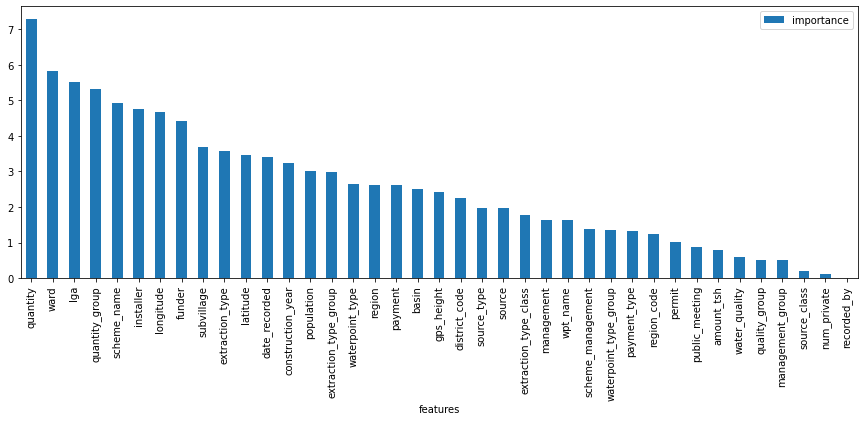

In [26]:
#Plot feature importance
features = pd.DataFrame([feat_names,feat_imp]).T
features.columns = ['features','importance']
features.sort_values(by = 'importance', ascending = False).plot.bar(x='features', y='importance',figsize=(15,5))

In [27]:
# How many features capture 90% of the variance in the dataset?
(features.importance.sort_values(ascending = False).cumsum()<90).sum()

25

In [28]:
# Load in competition test set to score base model.
X_comp_model = X_comp.drop(['id'], axis = 1)
y_comp = pd.DataFrame(cb.predict(X_comp_model.astype(str), prediction_type = 'Class'), columns =['status_group'])
y_comp.index.name = 'id'
y_comp.index = X_comp.id

In [29]:
# Store base model predictions for submission on the DRIVENDATA website
y_comp.to_csv('y_comp_m0.csv', sep=',')

## Model 0 Comments

- The model returned a list of features that appear to explain majority of the variance in the dataset. 25 Features explained 90% of the variance in the data. We will use this feature subset and apply preporcessing to impute any missing values
- The model had an average accuracy score of 80%
- We will use this as a reference point to judge later models and reference this classification report for subsequent models

## MODEL 1:  Feature Selection, Preprocessing, Parameter Tuning - CatBoost

Model 1 leverages the feature importance found in model 0 for feature selection and also attempts to code true missing values from values of 0 to true np.nan values.  


In [30]:
# Select the top features from model 0 above
feat_sorted = features.sort_values(by = 'importance', ascending = False)
feat_selected = list(feat_sorted.features.head(26))

In [31]:
X_train_m1 = X_train[feat_selected]

In [32]:
X_train_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 43069 to 56422
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quantity               41580 non-null  object 
 1   ward                   41580 non-null  object 
 2   lga                    41580 non-null  object 
 3   quantity_group         41580 non-null  object 
 4   scheme_name            21866 non-null  object 
 5   installer              39044 non-null  object 
 6   longitude              41580 non-null  float64
 7   funder                 39053 non-null  object 
 8   subvillage             41316 non-null  object 
 9   extraction_type        41580 non-null  object 
 10  latitude               41580 non-null  float64
 11  date_recorded          41580 non-null  object 
 12  construction_year      41580 non-null  int64  
 13  population             41580 non-null  int64  
 14  extraction_type_group  41580 non-null  object 
 15

With our new selected features, the following will be cleaned further for missing values OR 0 values

**CATEGORICAL**: funder, scheme_name, installer, subvillage, scheme_management.

**NUMERICAL:** gps_height, construction_year, population, longitude, latitude (as seen earlier with multiple zeros)

In [33]:
#Create a clean_x function to prepare X variables

def clean_x(df):
    '''
    function to replace values that are believed to be missing with np.nan for X variables. 
    Input - df with Features
    Output - cleaned df with engineered column of age of water pump
    
    '''
    df = df[feat_selected]
    
    #replace 0 values as true NaN
    # replace 0 values with np.NaN so they appear as missing rather than 0

    df.gps_height.replace(0, np.NaN, inplace = True)
    df.construction_year.replace(0, np.NaN, inplace = True)
    df.population.replace(0, np.NaN, inplace = True)
    df.longitude.replace(0, np.NaN, inplace = True)
    df.latitude.replace(-0.00000002, np.NaN, inplace = True)
    
    # create new column for the year the waterpoint was constructed
    df['year_recorded'] = pd.to_datetime(df['date_recorded']).dt.year
    #Add new column denoting the estimated age of the waterpoint
    df['age'] = df['year_recorded'] - df['construction_year']
    #drop date recorded column since we have a new measure for the estimated age of the water source
    df = df.drop(['date_recorded'], axis = 1)
    
    # Convert Categorical features to str values
    categorical_features = list(df.select_dtypes(include=['object']).columns)
    df[categorical_features] = df[categorical_features].astype(str, copy=False)
    
    return df
    
# Create function to prepare inputdata for X_train & X_test

def prepare_inputs(X_train, X_test, X_comp):
    '''
    function prepare train, test and competition features  
    Input - df with Features
    Output - 3 dfs clean_x function applied
    
    '''
    X_train_m1 = clean_x(X_train)
    X_test_m1 = clean_x(X_test)
    X_comp_m1 = clean_x(X_comp)
    
    return X_train_m1, X_test_m1, X_comp_m1

In [34]:
# Prepare input data 
X_train_m1, X_test_m1, X_comp_m1 = prepare_inputs(X_train, X_test, X_comp)

In [35]:
#Initiate cb model
cat_features1 = clean_x(X).select_dtypes(include=['object']).columns.values
cbm1 = CatBoostClassifier(cat_features = cat_features1, 
                          loss_function = 'MultiClass',
                          random_seed=42,
                          task_type = 'GPU')


In [36]:
#Prepare input & ouput data
train_dataset_m1 = Pool(data=X_train_m1.astype(str),
                     label=y_train,
                     cat_features=cat_features1)

eval_dataset_m1 = Pool(data=X_test_m1.astype(str),
                    label=y_test,
                    cat_features=cat_features1)


In [38]:
#Find best parameters for model 1

grid = {'depth': [3,10],
        'iterations': [1000,3000],
        'l2_leaf_reg': [3,5],
        'learning_rate': [0.1, 0.03, 0.05]}

gs_catb_m1 = cbm1.grid_search(grid, 
                           X = X_train_m1, 
                           y = y_train, 
                           plot=True,
                           cv=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5439511254
bestIteration = 998
0:	loss: 0.5439511	best: 0.5439511 (0)	total: 13.8s	remaining: 5m 17s
bestTest = 0.5681584493
bestIteration = 999
1:	loss: 0.5681584	best: 0.5439511 (0)	total: 27.2s	remaining: 4m 59s
bestTest = 0.5565397511
bestIteration = 999
2:	loss: 0.5565398	best: 0.5439511 (0)	total: 39.1s	remaining: 4m 33s
bestTest = 0.544641448
bestIteration = 990
3:	loss: 0.5446414	best: 0.5439511 (0)	total: 51.1s	remaining: 4m 15s
bestTest = 0.5685475594
bestIteration = 999
4:	loss: 0.5685476	best: 0.5439511 (0)	total: 1m 3s	remaining: 4m
bestTest = 0.5571650752
bestIteration = 998
5:	loss: 0.5571651	best: 0.5439511 (0)	total: 1m 16s	remaining: 3m 49s
bestTest = 0.5246057111
bestIteration = 2997
6:	loss: 0.5246057	best: 0.5246057 (6)	total: 1m 49s	remaining: 4m 25s
bestTest = 0.5451869772
bestIteration = 2999
7:	loss: 0.5451870	best: 0.5246057 (6)	total: 2m 26s	remaining: 4m 53s
bestTest = 0.5353552968
bestIteration = 2999
8:	loss: 0.5353553	best: 0.5246057 (6)	tota

In [39]:
params_m1 = gs_catb_m1['params']
cbm1_best = CatBoostClassifier(cat_features = cat_features1, 
                              loss_function = 'MultiClass',
                              task_type = 'GPU').set_params(** params_m1)

In [40]:
params_m1

{'depth': 10, 'iterations': 3000, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

In [41]:
# Fit Model 1
cbm1_best.fit(train_dataset_m1)
y_pred_catb_m1 = cbm1_best.predict(eval_dataset_m1, prediction_type = 'Class')

0:	learn: 1.0840585	total: 61.1ms	remaining: 3m 3s
1:	learn: 1.0680089	total: 124ms	remaining: 3m 6s
2:	learn: 1.0523561	total: 183ms	remaining: 3m 2s
3:	learn: 1.0383653	total: 236ms	remaining: 2m 57s
4:	learn: 1.0205025	total: 309ms	remaining: 3m 5s
5:	learn: 1.0023406	total: 370ms	remaining: 3m 4s
6:	learn: 0.9855776	total: 432ms	remaining: 3m 4s
7:	learn: 0.9686501	total: 501ms	remaining: 3m 7s
8:	learn: 0.9527355	total: 579ms	remaining: 3m 12s
9:	learn: 0.9374341	total: 644ms	remaining: 3m 12s
10:	learn: 0.9237563	total: 713ms	remaining: 3m 13s
11:	learn: 0.9098963	total: 774ms	remaining: 3m 12s
12:	learn: 0.8973642	total: 844ms	remaining: 3m 13s
13:	learn: 0.8851718	total: 909ms	remaining: 3m 13s
14:	learn: 0.8733879	total: 972ms	remaining: 3m 13s
15:	learn: 0.8622643	total: 1.04s	remaining: 3m 13s
16:	learn: 0.8515439	total: 1.11s	remaining: 3m 14s
17:	learn: 0.8417885	total: 1.17s	remaining: 3m 14s
18:	learn: 0.8317816	total: 1.24s	remaining: 3m 13s
19:	learn: 0.8227695	total: 

In [42]:
#Calssification report of model 1 
print(classification_report(y_test, y_pred_catb_m1, digits = 5))

                         precision    recall  f1-score   support

             functional    0.80051   0.90374   0.84900      9724
functional needs repair    0.62276   0.29621   0.40147      1293
         non functional    0.83941   0.76834   0.80230      6803

               accuracy                        0.80797     17820
              macro avg    0.75423   0.65610   0.68426     17820
           weighted avg    0.80246   0.80797   0.79870     17820



In [43]:
# Load in competition test set to score model 1
y_comp_m1 = pd.DataFrame(cbm1_best.predict(X_comp_m1.astype(str), prediction_type = 'Class'), columns =['status_group'])
y_comp_m1.index.name = 'id'
y_comp_m1.index = X_comp.id

In [44]:
# Store  model predictions for model1
y_comp_m1.to_csv('y_comp_m1.csv', sep=',')

## Model 1 Comments

- Using the feature selection from model 0, Model leveraged 26 key features that explained 90% of the variance in the data
- The model had an average accuracy score of 80.797%,  better than the base model.
- This model had slight modifications by replacing some 0 values with true NaNs. CatBoost treats these NaNs as missing for a reason so there was no imputation done on missing values in this round. 

## MODEL 2 Feature Selection, Preprocessing, Imputation & Tuning - CatBoost


Model 2 builds on both models 0 & model 1 by:
- Using feature selection variables 
- using the same clean_x function for preprocessing

The new additions in this model are: 
- imputation of missing values


In [45]:
# Create column transformer pipelines for X variables:
# transforming numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = list(X_train_m1.select_dtypes(include=numerics).columns)

numeric_pipe = Pipeline(steps=[
    ('num_imputer', IterativeImputer(initial_strategy ='mean', 
                                     imputation_order = 'descending')),
    ('scaler', StandardScaler())])    

# transforming categorical features 
categorical_features = list(X_train_m1.select_dtypes(include=['object']).columns)

categ_pipe = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent'))
    ])

# column transformer
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_pipe, numeric_features),
        ('cat', categ_pipe, categorical_features)
    ])

def impute_x_m2(X_train_m1, X_test_m1, X_comp_m1):
    '''
    function to run preprocessor and impute missing categorical & numeric values + scale numerical variables 
    Input - df with  categorical & numeric features
    Output - 3 dfs with preprocessing column transformer applied
    
    '''
    X_train_m2 = pd.DataFrame(preprocessor.fit_transform(X_train_m1), columns= numeric_features+categorical_features)
    X_test_m2 = pd.DataFrame(preprocessor.transform(X_test_m1), columns = numeric_features+categorical_features)
    X_comp_m2 = pd.DataFrame(preprocessor.transform(X_comp_m1), columns = numeric_features+categorical_features)
    
    return X_train_m2, X_test_m2, X_comp_m2


In [46]:
X_train_m2, X_test_m2, X_comp_m2 = impute_x_m2(X_train_m1, X_test_m1, X_comp_m1)

In [47]:
cat_features2 = categorical_features
#Initiate cb2 model
cbm2 = CatBoostClassifier(cat_features = cat_features2, 
                          loss_function = 'MultiClass',
                          random_seed=42,
                          task_type = 'GPU')


In [48]:
#Prepare input & ouput data
train_dataset_m2 = Pool(data=X_train_m2.astype(str),
                     label=y_train,
                     cat_features=cat_features2)

eval_dataset_m2 = Pool(data=X_test_m2.astype(str),
                    label=y_test,
                    cat_features=cat_features2)


In [49]:
#Find best parameters for model 2

grid2 = {'depth': [3,10],
        'iterations': [1000,3000],
        'l2_leaf_reg': [3,5],
        'learning_rate': [0.1, 0.03, 0.05]}

gs_catb_m2 = cbm2.grid_search(grid2, 
                           X = X_train_m2, 
                           y = y_train, 
                           plot=True,
                           cv=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5435264334
bestIteration = 997
0:	loss: 0.5435264	best: 0.5435264 (0)	total: 14.3s	remaining: 5m 29s
bestTest = 0.5665618471
bestIteration = 999
1:	loss: 0.5665618	best: 0.5435264 (0)	total: 27.1s	remaining: 4m 57s
bestTest = 0.556124806
bestIteration = 998
2:	loss: 0.5561248	best: 0.5435264 (0)	total: 39.6s	remaining: 4m 37s
bestTest = 0.5443588484
bestIteration = 995
3:	loss: 0.5443588	best: 0.5435264 (0)	total: 51.7s	remaining: 4m 18s
bestTest = 0.5668307658
bestIteration = 999
4:	loss: 0.5668308	best: 0.5435264 (0)	total: 1m 3s	remaining: 4m 2s
bestTest = 0.5562852765
bestIteration = 998
5:	loss: 0.5562853	best: 0.5435264 (0)	total: 1m 16s	remaining: 3m 49s
bestTest = 0.5244107744
bestIteration = 2999
6:	loss: 0.5244108	best: 0.5244108 (6)	total: 1m 48s	remaining: 4m 23s
bestTest = 0.5434233283
bestIteration = 2999
7:	loss: 0.5434233	best: 0.5244108 (6)	total: 2m 26s	remaining: 4m 52s
bestTest = 0.5347543985
bestIteration = 2999
8:	loss: 0.5347544	best: 0.5244108 (6)	t

In [50]:
params_m2 = gs_catb_m2['params']
cbm2_best = CatBoostClassifier(cat_features = cat_features2, 
                              loss_function = 'MultiClass',
                              task_type = 'GPU').set_params(** params_m2)

In [51]:
params_m2

{'depth': 10, 'iterations': 3000, 'l2_leaf_reg': 3, 'learning_rate': 0.03}

In [52]:
# Fit best parameters on Model 2
cbm2_best.fit(train_dataset_m2)
y_pred_catb_m2 = cbm2_best.predict(eval_dataset_m2, prediction_type = 'Class')

0:	learn: 1.0837998	total: 58.3ms	remaining: 2m 54s
1:	learn: 1.0673994	total: 122ms	remaining: 3m 3s
2:	learn: 1.0513840	total: 185ms	remaining: 3m 4s
3:	learn: 1.0373136	total: 243ms	remaining: 3m 1s
4:	learn: 1.0191966	total: 312ms	remaining: 3m 7s
5:	learn: 1.0006440	total: 378ms	remaining: 3m 8s
6:	learn: 0.9836124	total: 443ms	remaining: 3m 9s
7:	learn: 0.9664828	total: 502ms	remaining: 3m 7s
8:	learn: 0.9501636	total: 579ms	remaining: 3m 12s
9:	learn: 0.9346913	total: 645ms	remaining: 3m 12s
10:	learn: 0.9205821	total: 733ms	remaining: 3m 19s
11:	learn: 0.9067861	total: 808ms	remaining: 3m 21s
12:	learn: 0.8937170	total: 896ms	remaining: 3m 25s
13:	learn: 0.8811943	total: 968ms	remaining: 3m 26s
14:	learn: 0.8697713	total: 1.04s	remaining: 3m 27s
15:	learn: 0.8584463	total: 1.11s	remaining: 3m 27s
16:	learn: 0.8476329	total: 1.18s	remaining: 3m 27s
17:	learn: 0.8373578	total: 1.26s	remaining: 3m 28s
18:	learn: 0.8273533	total: 1.33s	remaining: 3m 28s
19:	learn: 0.8179690	total: 

In [53]:
#Classification report of model 2 
print(classification_report(y_test, y_pred_catb_m2, digits = 5))

                         precision    recall  f1-score   support

             functional    0.80015   0.90539   0.84952      9724
functional needs repair    0.63077   0.28538   0.39297      1293
         non functional    0.84034   0.76981   0.80353      6803

               accuracy                        0.80864     17820
              macro avg    0.75708   0.65353   0.68201     17820
           weighted avg    0.80320   0.80864   0.79884     17820



In [54]:
# Load in competition test set to score model 2
y_comp_m2 = pd.DataFrame(cbm2_best.predict(X_comp_m2.astype(str), prediction_type = 'Class'), columns =['status_group'])
y_comp_m2.index.name = 'id'
y_comp_m2.index = X_comp.id

In [55]:
# Store  model predictions for model1
y_comp_m2.to_csv('y_comp_m2.csv', sep=',')

## Model 2 Comments
Using the feature selection from model 0, Model 2 used key features that explained 90% of the variance in the data
The model had an average accuracy score of 0.808%. The imputation of missing values appeared to have helped score better than the previous model as well.
 

## MODEL 3: Feature Selection, Preprocessing, Tuning (Class Weights) - CatBoost

Based on the learning from previous models. This model will attempt to run grid search while adjusting the weights of the classes. Imputation did not yeild significantly better results so we will leave missing values as missing. 


In [56]:
# Create column transformer pipelines for X variables:
# transforming numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = list(X_train_m1.select_dtypes(include=numerics).columns)

numeric_pipe3 = Pipeline(steps=[
    ('num_imputer', IterativeImputer(initial_strategy ='mean', 
                                     imputation_order = 'descending')),
    ('scaler', StandardScaler())])    

# transforming categorical features 
categorical_features = list(X_train_m1.select_dtypes(include=['object']).columns)

categ_pipe3 = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant',
                                  fill_value = np.nan))
    ])

# column transformer
preprocessor3 = ColumnTransformer(transformers=[
        ('num', numeric_pipe3, numeric_features),
        ('cat', categ_pipe3, categorical_features)
    ])

def impute_x_m3(X_train_m1, X_test_m1, X_comp_m1):
    '''
    function to run preprocessor and impute missing numeric values only  + scale numerical variables. 
    Missing categorical values are left as np.nan
    Input - df with  categorical & numeric features
    Output - 3 dfs with preprocessing column transformer applied
    
    '''
    X_train_m3 = pd.DataFrame(preprocessor3.fit_transform(X_train_m1), columns= numeric_features+categorical_features)
    X_test_m3 = pd.DataFrame(preprocessor3.transform(X_test_m1), columns = numeric_features+categorical_features)
    X_comp_m3 = pd.DataFrame(preprocessor3.transform(X_comp_m1), columns = numeric_features+categorical_features)
    
    return X_train_m3, X_test_m3, X_comp_m3

In [57]:
# Prepare input data
X_train_m3, X_test_m3, X_comp_m3 = impute_x_m3(X_train_m1, X_test_m1, X_comp_m1)

# Inititate CB model
cbm3 = CatBoostClassifier(cat_features = categorical_features, 
                          loss_function = 'MultiClass',
                          random_seed=42,
                          task_type = 'GPU')

#Prepare train & eval data

train_dataset_m3 = Pool(data=X_train_m3.astype(str),
                     label=y_train,
                     cat_features=categorical_features)

eval_dataset_m3 = Pool(data=X_test_m3.astype(str),
                    label=y_test,
                    cat_features=categorical_features)

# Parameters grid for model 3 & Weight formula for class imbalance
grid3 = {'depth': [4,6,10],
         'iterations': [1000,3000],
         'l2_leaf_reg': [3, 5, 9],
         'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced'],
         'learning_rate': [0.03, 0.05, 0.1]}

In [58]:
# Randomized Search on Param grid
gs_catb_m3 = cbm3.randomized_search(grid3, 
                                    X = X_train_m3, 
                                    y = y_train, 
                                    n_iter = 30,
                                    plot=True,
                                    cv=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5283776779
bestIteration = 999
0:	loss: 0.5283777	best: 0.5283777 (0)	total: 15.8s	remaining: 7m 37s
bestTest = 0.5406094873
bestIteration = 999
1:	loss: 0.5406095	best: 0.5283777 (0)	total: 30.2s	remaining: 7m 2s
bestTest = 0.5535627386
bestIteration = 999
2:	loss: 0.5535627	best: 0.5283777 (0)	total: 44.9s	remaining: 6m 44s
bestTest = 0.5208788381
bestIteration = 2999
3:	loss: 0.5208788	best: 0.5208788 (3)	total: 1m 22s	remaining: 8m 55s
bestTest = 0.5145646499
bestIteration = 2999
4:	loss: 0.5145646	best: 0.5145646 (4)	total: 2m 6s	remaining: 10m 30s
bestTest = 0.5224927615
bestIteration = 2999
5:	loss: 0.5224928	best: 0.5145646 (4)	total: 2m 49s	remaining: 11m 17s
bestTest = 0.5316949489
bestIteration = 999
6:	loss: 0.5316949	best: 0.5145646 (4)	total: 3m 3s	remaining: 10m 2s
bestTest = 0.5192279238
bestIteration = 2999
7:	loss: 0.5192279	best: 0.5145646 (4)	total: 3m 48s	remaining: 10m 27s
bestTest = 0.5283981698
bestIteration = 999
8:	loss: 0.5283982	best: 0.5145646 

In [59]:
params_m3 = gs_catb_m3['params']
params_m3

{'auto_class_weights': 'Balanced',
 'depth': 10,
 'iterations': 3000,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03}

In [60]:
# Train model 3 on the best found parameters

cbm3_best = CatBoostClassifier(cat_features = categorical_features, 
                              loss_function = 'MultiClass',
                              task_type = 'GPU').set_params(** params_m3)

cbm3_best.fit(train_dataset_m3)
y_pred_catb_m3 = cbm3_best.predict(eval_dataset_m3, prediction_type = 'Class')

0:	learn: 1.0903556	total: 60.7ms	remaining: 3m 2s
1:	learn: 1.0794848	total: 133ms	remaining: 3m 18s
2:	learn: 1.0693146	total: 189ms	remaining: 3m 9s
3:	learn: 1.0585936	total: 248ms	remaining: 3m 5s
4:	learn: 1.0485066	total: 313ms	remaining: 3m 7s
5:	learn: 1.0372666	total: 377ms	remaining: 3m 8s
6:	learn: 1.0278519	total: 461ms	remaining: 3m 17s
7:	learn: 1.0174356	total: 529ms	remaining: 3m 17s
8:	learn: 1.0062361	total: 596ms	remaining: 3m 18s
9:	learn: 0.9955889	total: 664ms	remaining: 3m 18s
10:	learn: 0.9851676	total: 738ms	remaining: 3m 20s
11:	learn: 0.9755500	total: 805ms	remaining: 3m 20s
12:	learn: 0.9664682	total: 879ms	remaining: 3m 21s
13:	learn: 0.9571409	total: 953ms	remaining: 3m 23s
14:	learn: 0.9486662	total: 1.02s	remaining: 3m 22s
15:	learn: 0.9409059	total: 1.08s	remaining: 3m 22s
16:	learn: 0.9328588	total: 1.16s	remaining: 3m 23s
17:	learn: 0.9254233	total: 1.23s	remaining: 3m 23s
18:	learn: 0.9179865	total: 1.29s	remaining: 3m 23s
19:	learn: 0.9104373	total

In [61]:
#Calssification report of model 3 
print(classification_report(y_test, y_pred_catb_m3, digits = 5))

                         precision    recall  f1-score   support

             functional    0.82045   0.85006   0.83499      9724
functional needs repair    0.42857   0.45940   0.44345      1293
         non functional    0.83409   0.77966   0.80596      6803

               accuracy                        0.79484     17820
              macro avg    0.69437   0.69637   0.69480     17820
           weighted avg    0.79722   0.79484   0.79550     17820



In [62]:
# Load in competition test set to score model 3
y_comp_m3 = pd.DataFrame(cbm3_best.predict(X_comp_m3.astype(str), prediction_type = 'Class'), columns =['status_group'])
y_comp_m3.index.name = 'id'
y_comp_m3.index = X_comp.id
#Store  model predictions for model1
y_comp_m3.to_csv('y_comp_m3.csv', sep=',')

## Model 3 Comments

The model has the lowest accuracy of all attempts @ 0.795. The model does have the strongest f1 score for the underrepresented class given the parameter tuning and the optimal model using balanced class weights versus all other models that set class weights to a default of 1.



## Results & Conclusions

In [66]:
print('The Micro F1 Score for Model 0 is', f1(y_test, y_pred_catb, average='micro'))
print('The Micro F1 Score for Model 1 is', f1(y_test, y_pred_catb_m1, average='micro'))
print('The Micro F1 Score for Model 2 is', f1(y_test, y_pred_catb_m2, average='micro'))
print('The Micro F1 Score for Model 3 is', f1(y_test, y_pred_catb_m3, average='micro'))

The Micro F1 Score for Model 0 is 0.8016273849607183
The Micro F1 Score for Model 1 is 0.8079685746352413
The Micro F1 Score for Model 2 is 0.8086419753086419
The Micro F1 Score for Model 3 is 0.7948372615039281


Model 2 Performed the best of all the models based on the f1 micro score. While the improvement isn't drastic, it appears imputation, feature selection and some data cleansing gave the model more credibility over a basic model run on default paramters and no pre-processing. 

In a world where the objective focused on pumps that need repair. Model 3 has the best f1 score of all as it balances the support for the classes during training. Model 3 Precision is 43% vs model 2 @ 63%, but recall is ~46% vs 29% for model 2. This means model 2 is more likely not to mislabel pumps that need repairs, model 3 is more likely to find more pumps that need repairs.

## Reflection, Comments & Improvement
The setup of the modelling was initially a challenge given the failed attempt at One-Hot-Encoding and dimension reduction. Data exploration was fairly interesting as a lot of fields were similarand had similar loopholes. Pretty clear example of real world data and the cleansing process required before modelling.

There is room to explore other feature selection methods like Chi-Squared Feature Selection or 
Mutual Information Feature Selection as both pertain to categorical variables. 

I also imagine there can be further feature engineering particularly with the geolocation features (longitude, latitude). They can be used to calculate distance from major cities/ water bodies which could provide more insight into the state of a pump.

Future exploration could also include other models that handle categorical variables like LightGBM and H2oGBM. 